In [1]:

from sogym.env import sogym
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from sogym.mmc_optim import run_mmc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import json
from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.expert_generation import generate_expert_dataset
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import gymnasium as gym
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.data import random_split
from sogym.utils import profile_and_analyze


%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [ ]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [ ]:
from sogym.expert_generation import generate_mmc_solutions,generate_dataset

dataset_folder = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
#generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")
generate_dataset(dataset_folder= dataset_folder, num_threads=30, num_samples=100)

In [ ]:
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

In [2]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='image',vol_constraint_type='hard',resolution=50,check_connectivity = False)
eval_env = sogym(mode='test',observation_type='image',vol_constraint_type='hard',resolution=50)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Initialize the index for the current subplot
subplot_index = 0

# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward == 0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, truncated, info = train_env.step(action)
        
        # Plot the current observation image
        axes[subplot_index].imshow(obs['image'].T, cmap='gray')
        axes[subplot_index].axis('off')
        axes[subplot_index].set_title(f"Timestep {subplot_index+1}")
        
        # Increment the subplot index
        subplot_index += 1
        
        # If all subplots are filled, display the plot and reset the index
        if subplot_index == len(axes):
            plt.tight_layout()
            plt.show()
            subplot_index = 0

# Print the reward
print("Reward:", reward)

# Plot the final state of the training environment
train_env.plot()

# Display any remaining subplots
if subplot_index > 0:
    for i in range(subplot_index, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
# Specify the number of permutations to generate
num_permutations = 1
observation_type = "image"

# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': 'image',
    'vol_constraint_type': 'hard',
    'seed': 42
}

directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False,num_processes = 28,num_permutations = 10)


Processing files: 100%|██████████| 215/215 [05:46<00:00,  1.61s/file]


<Figure size 640x480 with 0 Axes>

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)


/tmp/ipykernel_3467246/108980599.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(observation['image'].T)


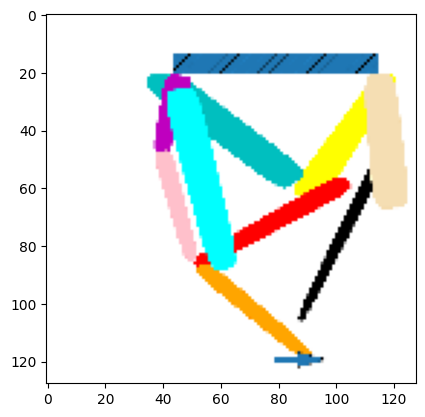

In [15]:
# Assuming you have the expert_dataset defined
expert_dataset = ExpertDataSet(expert_observations, expert_actions, train_env)
# Get a random sample from the dataset
sample_idx = np.random.randint(len(expert_dataset))
sample = expert_dataset[sample_idx]

# Extract the observation and reward from the sample
observation, reward = sample
plt.imshow(observation['image'].T)

In [38]:
import yaml
from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sogym.utils import ImageDictExtractor, CustomBoxDense
from datetime import datetime


chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

Train Epoch: 1 [0/30960 (0%)]	Loss: 1.553071	Grad Norm: 1.806783	LR: 0.010000
Train Epoch: 1 [35/30960 (16%)]	Loss: 1.620812	Grad Norm: 1.701824	LR: 0.010000
Train Epoch: 1 [70/30960 (32%)]	Loss: 1.534673	Grad Norm: 1.601043	LR: 0.010000
Train Epoch: 1 [105/30960 (48%)]	Loss: 1.548521	Grad Norm: 1.488831	LR: 0.010000
Train Epoch: 1 [140/30960 (65%)]	Loss: 1.554260	Grad Norm: 1.468470	LR: 0.010000
Train Epoch: 1 [175/30960 (81%)]	Loss: 1.567736	Grad Norm: 1.509041	LR: 0.010000
Train Epoch: 1 [210/30960 (97%)]	Loss: 1.564065	Grad Norm: 1.446244	LR: 0.010000
Train set: Average loss: 1.5597
Test set: Average loss: 1.5414
Train Epoch: 2 [0/30960 (0%)]	Loss: 1.503724	Grad Norm: 1.162373	LR: 0.009800
Train Epoch: 2 [35/30960 (16%)]	Loss: 1.518739	Grad Norm: 1.317596	LR: 0.009800
Train Epoch: 2 [70/30960 (32%)]	Loss: 1.591200	Grad Norm: 1.125701	LR: 0.009800
Train Epoch: 2 [105/30960 (48%)]	Loss: 1.540932	Grad Norm: 1.086520	LR: 0.009800
Train Epoch: 2 [140/30960 (65%)]	Loss: 1.500833	Grad Nor

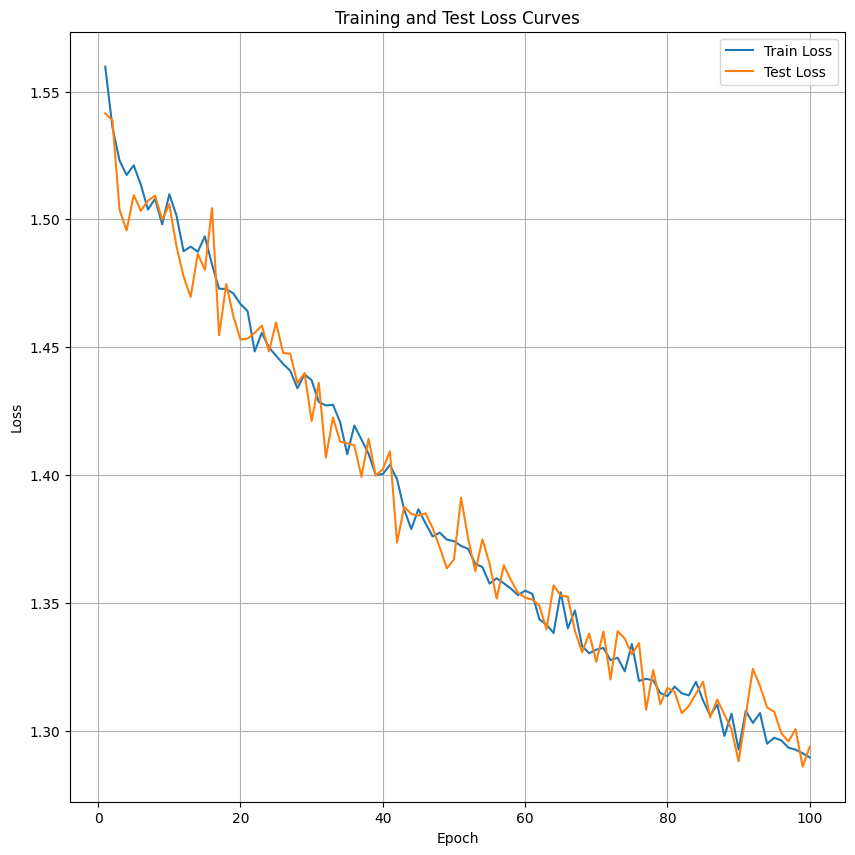

In [39]:
pretrain_agent(
    model,
    expert_observations,
    expert_actions,
    env,
    batch_size=1024,
    epochs=100,
    scheduler_gamma=0.98,
    learning_rate=1e-2,
    log_interval=5,
    no_cuda=False,
    seed=1,
    test_batch_size=512,
    early_stopping_patience=300,
    plot_curves=True,
)

---
### Multiprocessing

In [ ]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
# num_cpu = 
print("Using {} cpus!".format(num_cpu))
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


--- 
### Defining the model

In [ ]:
import yaml
from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sogym.utils import ImageDictExtractor, CustomBoxDense
from datetime import datetime


chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file


with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [ ]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback
from stable_baselines3.common.callbacks import CheckpointCallback


# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=5000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)



callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [ ]:
#model = SAC.load("model_saved_march15",env =env) #Saved model is with soft volume constraint and 75 r
#model.set_parameters("model_saved_march15")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

Desired volume: 0.43 Obtained volume: 0.022106626959891646


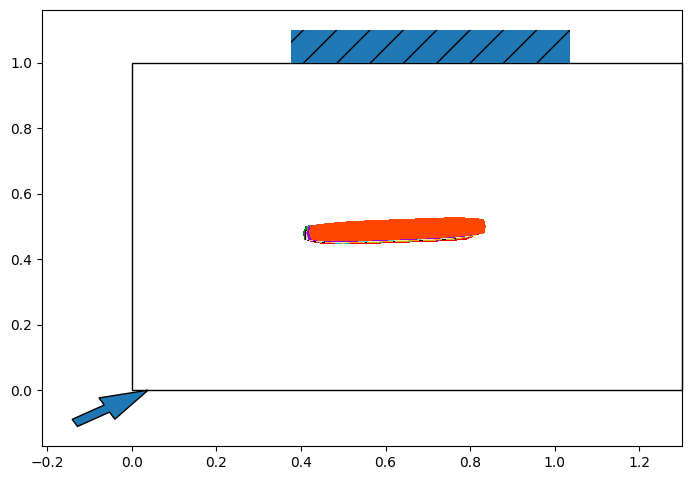

In [26]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    # print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
#print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')